Mounted at /content/drive
사용 장치: cuda
--- 1단계: 데이터 로드 및 3 분할 ---
데이터 분할 완료: Train: 196, Validation: 50, Test: 62


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at skt/kobert-base-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- 2단계: 학습 루프 시작 ---
Epoch 1/3 - Train Loss: 0.6644, Val Accuracy: 0.6800
Epoch 2/3 - Train Loss: 0.5906, Val Accuracy: 0.7800
Epoch 3/3 - Train Loss: 0.5636, Val Accuracy: 0.8000

학습 곡선 저장 완료: /content/drive/MyDrive/Colab Notebooks/training_curve.png

모델 저장 완료: /content/drive/MyDrive/Colab Notebooks/instruction_classifier_model/


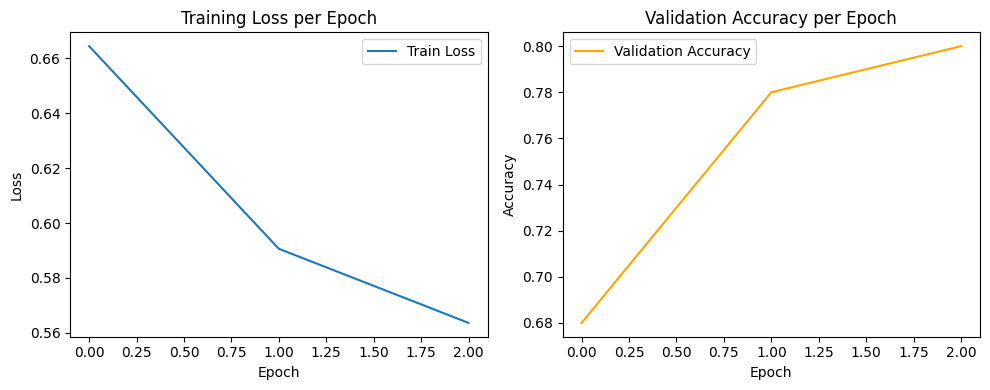

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from transformers import AutoTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os
from google.colab import drive

# =========================================================
# 0. 환경 설정 및 경로 정의 (Google Drive 마운트)
# =========================================================

# 1. Google Drive 마운트
drive.mount('/content/drive')

# ⚠️ 2. PROJECT_DIR 경로 설정 (사용자 경로에 맞게 반드시 수정하세요!)
# CSV 파일과 모델 폴더가 저장될 상위 폴더 경로여야 합니다.
PROJECT_DIR = '/content/drive/MyDrive/Colab Notebooks'

# 폴더가 없으면 생성
os.makedirs(PROJECT_DIR, exist_ok=True)

# 파일 경로 정의
CSV_FILE_PATH = os.path.join(PROJECT_DIR, "textbook_content.csv")
MODEL_DIR = os.path.join(PROJECT_DIR, "instruction_classifier_model")
CURVE_SAVE_PATH = os.path.join(PROJECT_DIR, 'training_curve.png')

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 장치: {device}")


# ============================
# 2. 데이터셋 정의 (InstructionDataset)
# ============================
class InstructionDataset(Dataset):
    def __init__(self, sentences, labels, tokenizer, max_len=64):
        self.sentences = sentences
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = str(self.sentences[idx])
        encoding = self.tokenizer.encode_plus(
            sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }


# ============================
# 3. 데이터 불러오기 & Train/Validation/Test 3 분할
# ============================
print("--- 1단계: 데이터 로드 및 3 분할 ---")
try:
    df = pd.read_csv(CSV_FILE_PATH, encoding='cp949')
except UnicodeDecodeError:
    df = pd.read_csv(CSV_FILE_PATH, encoding='utf-8')
except FileNotFoundError:
    print(f"❌ 오류: CSV 파일이 없습니다. 경로를 확인하세요: {CSV_FILE_PATH}")
    exit()

sentences = df["sentence"].tolist()
labels = df["label"].tolist()

# 1단계: 전체 데이터를 Train/Validation 그룹 (80%)과 Test 그룹 (20%)으로 분리
# Test set은 최종 평가를 위해 따로 보관합니다. (random_state=42로 재현성 확보)
train_val_s, test_s, train_val_l, test_l = train_test_split(
    sentences, labels, test_size=0.2, random_state=42, shuffle=True
)

# 2단계: 남은 Train/Validation 그룹을 다시 Train (80%)과 Validation (20%)으로 분리
train_s, val_s, train_l, val_l = train_test_split(
    train_val_s, train_val_l, test_size=0.2, random_state=42, shuffle=True
)

print(f"데이터 분할 완료: Train: {len(train_s)}, Validation: {len(val_s)}, Test: {len(test_s)}")

# 토크나이저 로드 (KoBERT는 AutoTokenizer로 로드)
tokenizer = AutoTokenizer.from_pretrained("skt/kobert-base-v1")

# DataLoader 준비
train_dataset = InstructionDataset(train_s, train_l, tokenizer)
val_dataset = InstructionDataset(val_s, val_l, tokenizer)
test_dataset = InstructionDataset(test_s, test_l, tokenizer) # Test set도 Dataset으로 준비

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


# ============================
# 4. 모델 정의 (BertForSequenceClassification)
# ============================
model = BertForSequenceClassification.from_pretrained(
    "skt/kobert-base-v1",
    num_labels=2
)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()


# ============================
# 5. 학습 함수 및 6. 평가 함수 정의
# ============================
def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_accuracy(model, loader):
    model.eval()
    corrects = 0
    total = 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask=mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            corrects += (predictions == labels).sum().item()
            total += labels.size(0)
    return corrects / total

def final_eval_model(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask=mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            preds.extend(predictions.cpu().numpy())
            trues.extend(labels.cpu().numpy())
    return classification_report(trues, preds, digits=4)


# ============================
# 7. 학습 루프 (Training)
# ============================
EPOCHS = 3
history = {'train_loss': [], 'val_accuracy': []}

print("\n--- 2단계: 학습 루프 시작 ---")
for epoch in range(EPOCHS):
    train_loss = train_epoch(model, train_loader, optimizer)
    val_accuracy = eval_accuracy(model, val_loader)

    history['train_loss'].append(train_loss)
    history['val_accuracy'].append(val_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# 학습 곡선 시각화 저장
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1); plt.plot(history['train_loss'], label='Train Loss'); plt.title('Training Loss per Epoch'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.subplot(1, 2, 2); plt.plot(history['val_accuracy'], label='Validation Accuracy', color='orange'); plt.title('Validation Accuracy per Epoch'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.tight_layout()
plt.savefig(CURVE_SAVE_PATH)
print(f"\n학습 곡선 저장 완료: {CURVE_SAVE_PATH}")


# ============================
# 8. 모델 저장 (재현 가능성 확보)
# ============================
model.save_pretrained(MODEL_DIR)
tokenizer.save_pretrained(MODEL_DIR)
print(f"\n모델 저장 완료: {MODEL_DIR}/")